# LDA discursos


## Librerías

In [1]:
# Regular expressions and os for path
import os
import re
import glob
from pathlib import Path

# Dataframe and statistics
import pandas as pd
import numpy as np

# Gensim for vector embedding
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# Spacy for text preprocessing
import spacy
nlp = spacy.load('en_core_web_lg')


# Latent Dirichlect Allocation
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt

In [2]:
import os
import PyPDF2
discursos = 'discursos/tfm'
texto_discursos = []

# Itera a través de cada archivo en la carpeta
for archivo_nombre in os.listdir(discursos):
    if archivo_nombre.endswith('.pdf'):
        # Construye la ruta completa del archivo
        archivo_ruta = os.path.join(discursos, archivo_nombre)
        
        # Abre el archivo PDF en modo de lectura binaria
        with open(archivo_ruta, 'rb') as archivo_pdf:
            # Crea un objeto PDFReader
            lector_pdf = PyPDF2.PdfReader(archivo_pdf)
            
            # Itera a través de cada página y extrae el texto
            texto_archivo = ''
            for pagina_num in range(len(lector_pdf.pages)):
                pagina = lector_pdf.pages[pagina_num]
                texto_archivo += pagina.extract_text()

            # Agrega el texto del archivo a la lista de discursos
            texto_discursos.append(texto_archivo)

# Ahora tienes una lista llamada texto_discursos que contiene el texto de todos los discursos en los archivos PDF de la carpeta.
# Puedes usar esta lista para realizar tu análisis de LDA u otras tareas de procesamiento de texto.

/home/codespace/.python/current/lib/python3.10/site-packages/PyPDF2/__init__.py:21: DeprecationWarning: PyPDF2 is deprecated. Please move to the pypdf library instead.
  warnings.warn(


In [3]:
df = pd.DataFrame(texto_discursos,columns=['texto'])
df.replace('\n', '.', regex=True, inplace=True)


In [4]:
pd.set_option('display.max_colwidth', 200)
df

,texto
0,". For release on delivery 2 p.m. EDT July 21, 2010 .Semiannual Monetary Policy Report to the Congress .Ben S. Bernanke .Chairman .Board of Governors of the Federal Reserve..."
1,"For release on delivery .10:00 a.m. EST .February 14,2007 .Statement of .Ben S. Bernanke .Chairman .Board of Governors of the Federal Reserve System .before the .Committee on Banking, Housing, and..."
2,"For release on delivery .10:00 a.m. E DT (8:00 a.m. MDT) .August 26, 2016 . . . . . . . . .The Federal Reserve’s Monetary Policy Toolkit : Past, Present , and Future . . . .Remarks by . .Jane..."
3,"Statement by .Ben S. Bernanke.Chairman .Board of Governors of the Federal Reserve System.provided for the record.of a hearing conducted by the.Subcommittee on Oversight of Government Management,.t..."
4,"For release on delivery .10:00 a.m. EDT .July 15, 2014 . . .Statement by . .Janet L. Yellen . .Chair . .Board of Governors of the Federal Reserve System . .before the . .Committee ..."
...,...
86,"For rel ease on delivery.10:00 a.m .EST.February 10, 2010.Statem ent by.Ben S. Bernanke .Chairman .Board of Governors of the Federal Reserve System.prepared for the.Committee on Financial Services..."
87,"For release on delivery .10:00 a.m. EDT (8:00 a.m. MDT) .August 31, 2007 .Housing, Housing Finance, and Monetary Policy .Remarks .by .Ben S. Bernanke .Chairman .Board of Governors of the Federal R..."
88,"For release on delivery .10:00 a.m. EDT .September 20, 2007 .Statement of .Ben S. Bernanke .Chainnan .Board of Governors of the Federal Reserve System .before the .Committee on Financial Services ..."
89,"For release on delivery .10:00 a.m. EDT (8:00 a.m. MDT) .August 24, 2018 . . . . . . . . .Monetary Policy in a Changing Economy . . . .Remarks by . .Jerome H. Powell . .Chairman . .Board o..."


## Tonkenization

In [5]:
df['texto'] = df.reset_index()['texto'].apply(lambda x: x.split('_')[0]).tolist()
df['clean_texto'] = df['texto'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
df['clean_texto'] = df['clean_texto'].apply(lambda x: ' '.join(x.lower().split()))

# Paso 2: Tokenizar el texto limpio
tokens = [t.split() for t in df['clean_texto']]

# Paso 3: Eliminar stopwords y agregar una nueva columna 'sin_stopwords' al DataFrame
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

df['sin_stopwords'] = df['clean_texto'].apply(remove_stopwords)

In [6]:
from collections import Counter

# Contar la frecuencia de las palabras en cada documento
word_counts_per_doc = [Counter(doc.split()) for doc in df['sin_stopwords']]

# Obtener las 5 palabras más repetidas por documento
top_words_per_doc = [[word for word, _ in doc.most_common(5)] for doc in word_counts_per_doc]

# Crear un DataFrame para mostrar los resultados
top_words_df = pd.DataFrame({'Top 5 palabras': top_words_per_doc})
top_words_df.index.name = 'Documento'

# Mostrar el DataFrame resultante
print(top_words_df)

                                                Top 5 palabras
Documento                                                     
0                     [small, business, credit, businesses, o]
1                    [inflation, year, policy, growth, prices]
2                      [s, federal, policy, reserve, monetary]
3                  [financial, education, federal, reserve, s]
4                   [inflation, committee, s, federal, policy]
...                                                        ...
86                         [federal, reserve, financial, s, y]
87                     [mortgage, housing, s, market, markets]
88         [mortgage, borrowers, subprime, federal, mortgages]
89                    [inflation, rate, s, unemployment, fomc]
90                [inflation, growth, recent, prices, economy]

[91 rows x 1 columns]


In [7]:
df.head(3)

,texto,clean_texto,sin_stopwords
0,". For release on delivery 2 p.m. EDT July 21, 2010 .Semiannual Monetary Policy Report to the Congress .Ben S. Bernanke .Chairman .Board of Governors of the Federal Reserve...",for release on delivery p m edt july semiannual monetary policy report to the congress ben s bernanke chairman board of governors of the federal reserve system before the committee on banking hous...,release delivery p m edt july semiannual monetary policy report congress ben s bernanke chairman board governors federal reserve committee banking housi ng urban affairs united states senate july ...
1,"For release on delivery .10:00 a.m. EST .February 14,2007 .Statement of .Ben S. Bernanke .Chairman .Board of Governors of the Federal Reserve System .before the .Committee on Banking, Housing, and...",for release on delivery a m est february statement of ben s bernanke chairman board of governors of the federal reserve system before the committee on banking housing and urban affairs united stat...,release delivery m est february statement ben s bernanke chairman board governors federal reserve committee banking housing urban affairs united states senate february chairman dodd senator shelby...
2,"For release on delivery .10:00 a.m. E DT (8:00 a.m. MDT) .August 26, 2016 . . . . . . . . .The Federal Reserve’s Monetary Policy Toolkit : Past, Present , and Future . . . .Remarks by . .Jane...",for release on delivery a m e dt a m mdt august the federal reserve s monetary policy toolkit past present and future remarks by janet l yellen chair board of governors of the federal reserve syst...,release delivery m e dt m mdt august federal reserve s monetary policy toolkit past present future remarks janet l yellen chair board governors federal reserve designing resilient monetary policy ...


## Lematización

In [8]:
 # Get our lemmas with Lemmatization (preferred over stemming)
from tqdm import tqdm
tqdm.pandas()

In [9]:
nlp = spacy.load("en_core_web_lg", disable=['parser', 'tagger', 'ner'])
df['lemmas'] = df['sin_stopwords'].progress_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True) and (len(token) > 2)])
df.head(2)

  0%|          | 0/91 [00:00<?, ?it/s]/home/codespace/.python/current/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 91/91 [00:06<00:00, 14.39it/s]


,texto,clean_texto,sin_stopwords,lemmas
0,". For release on delivery 2 p.m. EDT July 21, 2010 .Semiannual Monetary Policy Report to the Congress .Ben S. Bernanke .Chairman .Board of Governors of the Federal Reserve...",for release on delivery p m edt july semiannual monetary policy report to the congress ben s bernanke chairman board of governors of the federal reserve system before the committee on banking hous...,release delivery p m edt july semiannual monetary policy report congress ben s bernanke chairman board governors federal reserve committee banking housi ng urban affairs united states senate july ...,"[release, delivery, edt, july, semiannual, monetary, policy, report, congress, ben, bernanke, chairman, board, governors, federal, reserve, committee, banking, housi, urban, affairs, united, state..."
1,"For release on delivery .10:00 a.m. EST .February 14,2007 .Statement of .Ben S. Bernanke .Chairman .Board of Governors of the Federal Reserve System .before the .Committee on Banking, Housing, and...",for release on delivery a m est february statement of ben s bernanke chairman board of governors of the federal reserve system before the committee on banking housing and urban affairs united stat...,release delivery m est february statement ben s bernanke chairman board governors federal reserve committee banking housing urban affairs united states senate february chairman dodd senator shelby...,"[release, delivery, est, february, statement, ben, bernanke, chairman, board, governors, federal, reserve, committee, banking, housing, urban, affairs, united, states, senate, february, chairman, ..."


## Bag of words

In [10]:
# Dictionary representation of all the words in our corpus
# We get our Bag of Words representation
id2word = corpora.Dictionary(df['lemmas'])
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [11]:
id2word.filter_extremes(no_below=3, no_above=0.95)
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

## Latent Dirichlet Allocation

In [12]:
%%time
lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        random_state=42,
                                                        num_topics=10, 
                                                        chunksize=90,
                                                        passes=20,
                                                        per_word_topics=True,
                                                        workers=12)


lda_multicore.save('df_lda4.model')

CPU times: user 3.54 s, sys: 736 ms, total: 4.28 s
Wall time: 7.6 s


In [13]:
from gensim import models
lda_multicore =  models.LdaModel.load('df_lda4.model')

In [14]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_multicore.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
topics[0:15]

['policy inflation rate monetary economic',
 'inflation rate unemployment fomc policy',
 'financial firms important supervision act',
 'financial credit markets banks institutions',
 'financial bank markets liquidity mortgage',
 'financial rate economic term mortgage',
 'financial economic rate policy inflation',
 'budget fiscal gdp percent government',
 'economic inflation growth year policy',
 'small business credit businesses banks']

In [15]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [16]:
# Here we will use pyldavis to visualize the distribution of our principal components
pyLDAvis.gensim.prepare(lda_multicore, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.103633  0.097977       1        1  32.909039
3      0.106839  0.018341       2        1  22.615994
0     -0.117891  0.120957       3        1  19.133429
2      0.173645 -0.035937       4        1   9.681828
4      0.115395  0.058812       5        1   5.983964
9      0.072801  0.079363       6        1   4.907139
7     -0.136324 -0.166268       7        1   2.936681
1     -0.121920  0.043748       8        1   1.815400
6      0.005654 -0.108095       9        1   0.008264
5      0.005434 -0.108898      10        1   0.008264, topic_info=            Term         Freq        Total Category  logprob  loglift
661    inflation  1060.000000  1060.000000  Default  30.0000  30.0000
1039        rate   850.000000   850.000000  Default  29.0000  29.0000
501    financial  1531.000000  1531.000000  Default  28.0000  28.0000
952       policy   986.000000   986.000000  Default  27.0000  27.0000
924      percent   730.000000   730.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
517         fomc     0.002460   363.818366  Topic10  -8.2130  -2.5032
555   government     0.002444   200.391206  Topic10  -8.2195  -1.9133
1187  securities     0.002452   313.324516  Topic10  -8.2161  -2.3569
506        firms     0.002454   348.064596  Topic10  -8.2152  -2.4612
760       longer     0.002452   358.360191  Topic10  -8.2163  -2.4915

[743 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3954      7  0.838261         accept
2007      1  0.278575  accommodative
2007      3  0.689108  accommodative
2007      8  0.029324  accommodative
6         2  0.182365       accurate
...     ...       ...            ...
1443      3  0.050109           york
1443      4  0.217140           york
1443      5  0.334062           york
1443      6  0.183734           york
1443      8  0.016703           york

[1825 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 1, 3, 5, 10, 8, 2, 7, 6])

## Interpretar

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
%%time
# Apply our function
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['lemmas'], 
                                                        start=2, 
                                                        limit=22, 
                                                        step=4)

CPU times: user 41.4 s, sys: 11.9 s, total: 53.3 s
Wall time: 50.1 s


In [19]:
coherence_values

[0.4343086355614747,
 0.4709675663323267,
 0.4871975908574642,
 0.45704757335176627,
 0.4609742703044304]

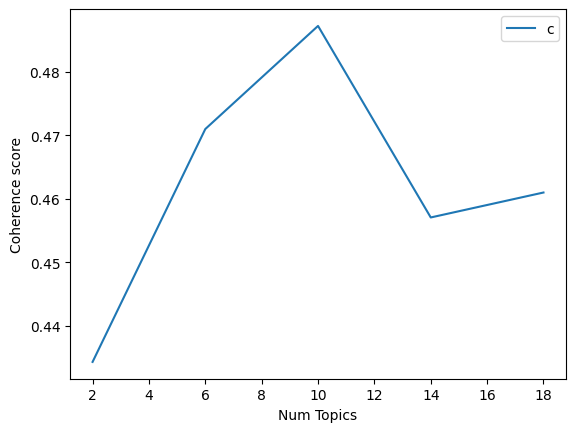

In [20]:
# Basic line chart
# Use a plotly or ggplot viz
limit=22; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " consists of a Coherence Value of", round(cv, 4))

Num Topics = 2  consists of a Coherence Value of 0.4343
Num Topics = 6  consists of a Coherence Value of 0.471
Num Topics = 10  consists of a Coherence Value of 0.4872
Num Topics = 14  consists of a Coherence Value of 0.457
Num Topics = 18  consists of a Coherence Value of 0.461


In [22]:
# Select the model and print the topics
optimal_model =  models.LdaModel.load('df_lda4.model')
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.023*"policy" + 0.020*"inflation" + 0.019*"rate" + 0.015*"monetary" + 0.013*"economic" + 0.013*"percent" + 0.011*"labor" + 0.010*"funds" + 0.008*"fomc" + 0.008*"year"'), (1, '0.027*"inflation" + 0.023*"rate" + 0.015*"unemployment" + 0.013*"fomc" + 0.011*"policy" + 0.009*"lehman" + 0.009*"growth" + 0.008*"time" + 0.008*"monetary" + 0.008*"natural"'), (2, '0.031*"financial" + 0.016*"firms" + 0.009*"important" + 0.009*"supervision" + 0.008*"act" + 0.008*"risk" + 0.008*"firm" + 0.007*"systemic" + 0.007*"capital" + 0.007*"systemically"'), (3, '0.030*"financial" + 0.011*"credit" + 0.011*"markets" + 0.008*"banks" + 0.007*"institutions" + 0.006*"bank" + 0.006*"mortgage" + 0.005*"capital" + 0.005*"risk" + 0.005*"term"'), (4, '0.018*"financial" + 0.017*"bank" + 0.011*"markets" + 0.009*"liquidity" + 0.009*"mortgage" + 0.008*"credit" + 0.007*"banks" + 0.007*"term" + 0.007*"paper" + 0.007*"crisis"'), (5, '0.000*"financial" + 0.000*"rate" + 0.000*"economic" + 0.000*"term" + 0.000*"mortgage" +

In [23]:
# Get a cleaner print for readability
for id, t in enumerate(topics):
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
policy inflation rate monetary economic

------ Topic 1 ------
inflation rate unemployment fomc policy

------ Topic 2 ------
financial firms important supervision act

------ Topic 3 ------
financial credit markets banks institutions

------ Topic 4 ------
financial bank markets liquidity mortgage

------ Topic 5 ------
financial rate economic term mortgage

------ Topic 6 ------
financial economic rate policy inflation

------ Topic 7 ------
budget fiscal gdp percent government

------ Topic 8 ------
economic inflation growth year policy

------ Topic 9 ------
small business credit businesses banks



: 